In [199]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
cwd = os.getcwd()
print('\t\tFiles in Directory:\n', os.listdir(cwd))

spam_dir = glob.glob(os.path.join(os.getcwd(), "spam", "*.txt"))
notspam_dir = glob.glob(os.path.join(os.getcwd(), "ham", "*.txt"))

		Files in Directory:
 ['.ipynb_checkpoints', 'div.png', 'divergence.png', 'FP_TM_JD&MD&SH.pptx', 'ham', 'merged.csv', 'spam', 'TM_FP_JakeDineen_POSTagging_NLP.ipynb']


In [200]:
def load_files(x, label):
    fill = []  #append text here
    badfiles = []  #storage for unreadable text
    counter = 0
    for i in range(0, len(x)):
        file = open(
            x[i],
            'r',
        )
        try:
            file = file.read()  #Read file
            file = file.strip(('\n'))  #Strip newlines
            file = file.replace('\n', ' ')  #Replace newlines
            file = file.replace('Subject:', '')
            fill.append((file))  #append to storage

        except:
            counter += 1
            badfiles.append(i)

    print("Couldn't read {} files: indices ={}".format(counter, badfiles))

    return pd.DataFrame({'text': fill, 'label': label})


spam = load_files(spam_dir, label= 'spam')
not_spam = load_files(notspam_dir, label = 'not_spam')

print("\nread in {} spam emails \nread in {} not_spam emails".format(
    len(spam), len(not_spam)))

spam_per = np.round(len(spam) / (len(spam) + len(not_spam)), 3)
not_spam_per = np.round(len(not_spam) / (len(spam) + len(not_spam)), 3)

print('\nDistribution of data: \nSpam:{}% \nNot Spam: {}%'.format(spam_per, not_spam_per))

Couldn't read 4 files: indices =[634, 714, 761, 1316]
Couldn't read 0 files: indices =[]

read in 1496 spam emails 
read in 3672 not_spam emails

Distribution of data: 
Spam:0.289% 
Not Spam: 0.711%


#### Some descriptive stuff

In [201]:
spam_string_counts = [len(nltk.word_tokenize(x)) for x in spam.text]
notspam_string_counts = [len(nltk.word_tokenize(x)) for x in not_spam.text]

#Token Counts
print('spam string average length:', np.mean(np.unique(spam_string_counts)))
print('not_spam string average length:', np.mean(np.unique(notspam_string_counts)))


#Char in string counts
spam_tokens = [nltk.word_tokenize(x) for x in spam.text]
spam_str_length = [len(x) for x in spam_tokens]


notspam_tokens = [nltk.word_tokenize(x) for x in not_spam.text]
notspam_string_length = [len(x) for x in notspam_tokens]

print('spam string average length:', np.mean(spam_str_length))
print('not_spam string average length:', np.mean(notspam_string_length))

spam string average length: 457.21062618595823
not_spam string average length: 523.8222222222222
spam string average length: 234.48128342245988
not_spam string average length: 224.23910675381265


C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\jdine\Documents\Anaconda3\envs\tensorflowlatest\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


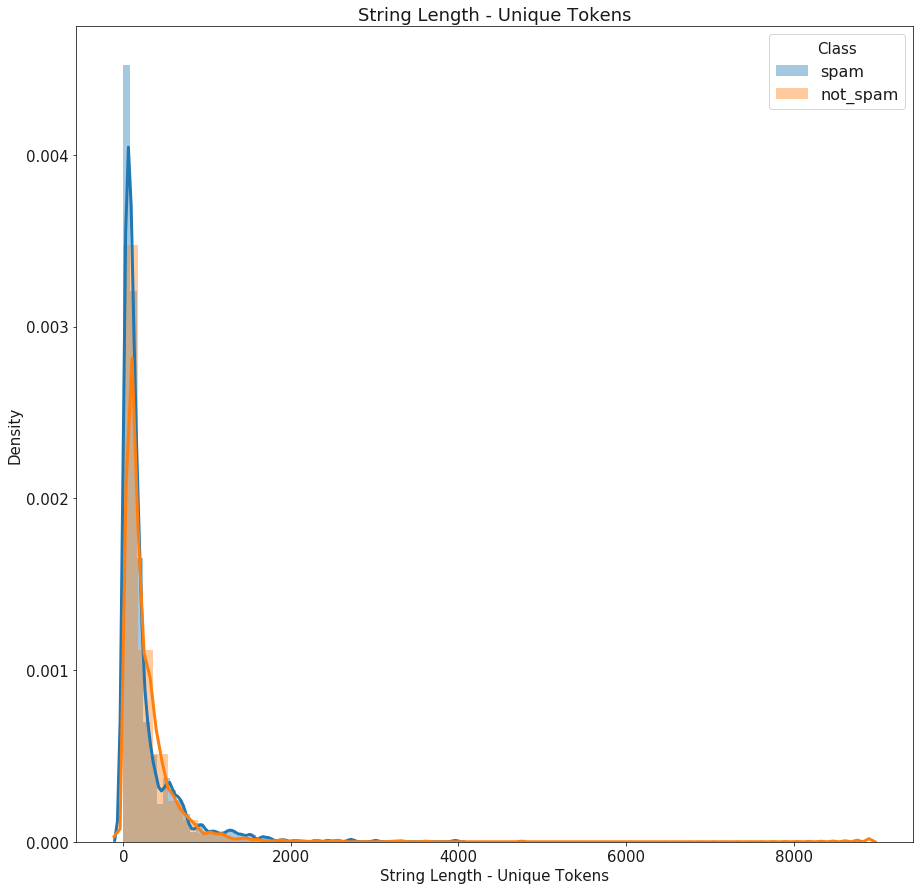

In [202]:
spam['unique_tokens'] = spam_string_counts
spam[:5]

not_spam['unique_tokens'] = notspam_string_counts

dfs = [spam, not_spam]
test123 = pd.concat(dfs)
test123[:5]

types = ['spam', 'not_spam']

for airline in types:
    # Subset to the airline
    subset = test123[test123['label'] == airline]
    
    # Draw the density plot
    sns.distplot(subset['unique_tokens'], hist = True, kde = True, norm_hist=True,
                 kde_kws = {'linewidth': 3},
                 label = airline)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Class')
plt.title('String Length - Unique Tokens')
plt.xlabel('String Length - Unique Tokens')
plt.ylabel('Density')
plt.show()




## Cleaning Spam

#### Removing some punctuation + case

In [203]:
import re
dfs = [spam, not_spam]
merged_df = pd.concat(dfs)

merged_df.text = merged_df.text.apply(lambda x: x.lower())  #To lowercase

merged_df.text = merged_df.text.apply(
    lambda x: re.sub(r'[^\w\s]', '', x))  #remove punctuation

merged_df.to_csv('merged.csv')

### Getting distributions of Parts of Speech

In [204]:
import nltk
from collections import Counter
import itertools
#nltk.download('averaged_perceptron_tagger')
#nltk.download('tagsets')
from nltk.data import load

def extract_pos(x, pop):
    spam_pos = []
    for i in list(x.text):
        text = nltk.word_tokenize(i)
        spam_pos.append(nltk.pos_tag(text))

    merged_s = list(itertools.chain(*spam_pos))
    pos_raw_s = [x[1] for x in merged_s]
    counts_s = Counter(pos_raw_s)
    counts_s = list(counts_s.most_common())
    counts_s.pop(pop)
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    x_s = [x[0] for x in counts_s]
    y_s = []
    for i in x_s:
        if '#' not in i:
            y_s.append(tagdict[i][0])
    df_spam = pd.DataFrame(counts_s, columns=['POS', 'count'])
    df_spam['Part_of_speech'] = y_s
    length = np.sum(df_spam['count'])
    df_spam['distribution_yes'] = df_spam['count'].divide(length)
    df_spam['distribution_no'] = 1 - df_spam['distribution_yes']
    return df_spam
    



In [205]:
spam_dist = extract_pos(x = spam, pop = -10)
spam_pos_probs = list(spam_dist[['distribution_yes', 'distribution_no']].itertuples(index=False, name=None))
y = spam_dist.Part_of_speech
spam_pos_probs = list(zip(y, spam_pos_probs))


In [197]:
spam_pos_probs[:5]

[('noun, common, singular or mass', (0.2763879056384023, 0.7236120943615977)),
 ('adjective or numeral, ordinal', (0.09904313868779831, 0.9009568613122017)),
 ('sentence terminator', (0.07281509054785448, 0.9271849094521455)),
 ('preposition or conjunction, subordinating',
  (0.06340633492429605, 0.936593665075704)),
 ('numeral, cardinal', (0.05432014889584142, 0.9456798511041585))]

In [163]:
not_spam_dist = extract_pos(x = not_spam, pop = -17)
notspam_pos_probs = list(not_spam_dist[['distribution_yes', 'distribution_no']].itertuples(index=False, name=None))
y = not_spam_dist.Part_of_speech
notspam_pos_probs = list(zip(y, notspam_pos_probs))

In [164]:
notspam_pos_probs[:5]

[('noun, common, singular or mass', (0.23660213781492964, 0.7633978621850703)),
 ('colon or ellipsis', (0.12415078399937675, 0.8758492160006233)),
 ('numeral, cardinal', (0.0803086575296442, 0.9196913424703558)),
 ('adjective or numeral, ordinal', (0.061043733787141216, 0.9389562662128588)),
 ('preposition or conjunction, subordinating',
  (0.059953036727032366, 0.9400469632729677))]

### A look at KL Divergence

In [193]:

pk = [x[1] for x in spam_pos_probs]
keys = [x[0] for x in spam_pos_probs]
dist = tuple([1/len(spam_pos_probs), 1 - (1/len(spam_pos_probs))])
dist
import scipy
entropy = []
#scipy.stats.entropy(pk[0], dist)

for i in pk:
    entropy.append(scipy.stats.entropy(i, dist))
    
list(zip(keys, np.round(entropy, 4)))

spam = pd.DataFrame(list(zip(keys, np.round(entropy, 4))))

In [8]:
pk = [x[1] for x in notspam_pos_probs]
keys = [x[0] for x in notspam_pos_probs]
dist = tuple([1/len(notspam_pos_probs), 1 - (1/len(notspam_pos_probs))])
entropy = []
#scipy.stats.entropy(pk[0], dist)

for i in pk:
    entropy.append(scipy.stats.entropy(i, dist))
    
notspam = pd.DataFrame(list(zip(keys, np.round(entropy, 4))))

In [52]:
merged = spam.merge(notspam, on = 0)
merged.columns = ['part_of_speech', 'spam_divergence', 'notspam_divergence']
#merged['difference'] = np.abs(merged['spam_divergence'] - merged['notspam_divergence'])
#merged.sort_values(by = 'difference', ascending= False)

#grouping tags together to reduce dimensionality.

pos = ['noun', 'adjective', 'punctuation', 'preposition/conjunction',
      'numeral', 'determiner', 'noun', 'punctuation', 'punctuation', 'verb', 'adverb',
      'conjunction', 'verb', 'pronoun', 'noun', 'verb', 'preposition', 'verb', 'verb', 'pronoun',
      'verb', 'punctuation', 'modal', 'punctuation', 'punctuation', 'punctuation',
      'adjective', 'punctuation', 'determiner', 'adjective', 'foreign', 'punctuation', 'punctuation',
       'adverb', 'particle', 'pronoun', 'adverb', 'existential', 'adverb', 'determiner',
       'interjection', 'pronoun', 'punctuation', 'noun']

merged['pos'] = pos
merged.drop(columns = 'part_of_speech', inplace= True)

In [194]:
spam

,0,1
0,"noun, common, singular or mass",0.4730
1,"adjective or numeral, ordinal",0.0725
2,sentence terminator,0.0360
3,"preposition or conjunction, subordinating",0.0252
4,"numeral, cardinal",0.0163
5,determiner,0.0116
6,"noun, common, plural",0.0112
7,colon or ellipsis,0.0047
8,comma,0.0017
9,"verb, base form",0.0016


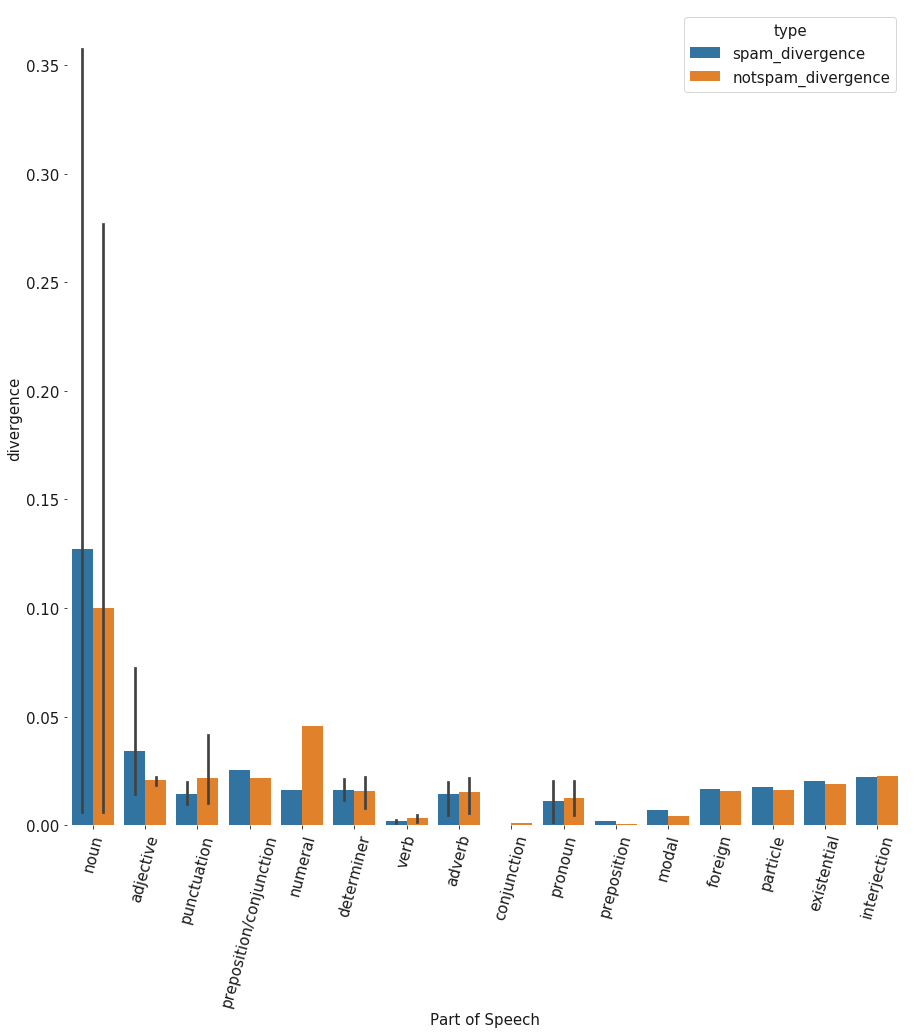

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 15)
plt.rcParams.update({'font.size': 15})
sns.set_color_codes("pastel")
#
#sns.barplot(x = merged['spam_divergence'], y = merged['part_of_speech'])
#plt.show()

test = merged.melt('pos', var_name= 'type', value_name= 'divergence')

ax=sns.barplot(x='pos', y='divergence', hue='type', orient = 'v', data=test)

ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
sns.despine(left=True, bottom=True)
plt.savefig('divergence.png')
plt.xlabel('Part of Speech')
plt.show()


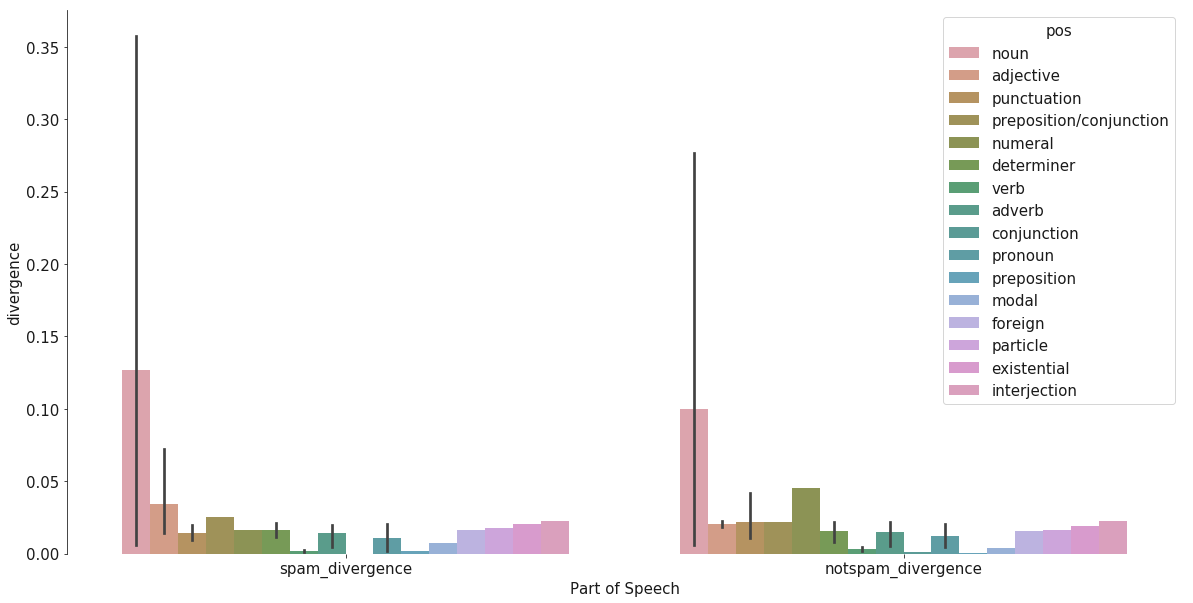

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({'font.size': 15})
sns.set_color_codes("pastel")
#
#sns.barplot(x = merged['spam_divergence'], y = merged['part_of_speech'])
#plt.show()

test = merged.melt('pos', var_name= 'type', value_name= 'divergence')

ax=sns.barplot(x='type', y='divergence', hue='pos', orient = 'v', saturation= .5, data=test)
 
sns.despine(right=True, bottom=True)
plt.savefig('divergence.png')
plt.xlabel('Part of Speech')
plt.show()


In [190]:
feature_ranks = sorted(zip(nb_clf.coef_[0], unigram_count_vectorizer.get_feature_names()))

ver_positive_10 = feature_ranks[-50:]
print("Spam words")
for i in range(0, len(ver_positive_10)):
    print(ver_positive_10[i])
print()

not_very_pos_10 = feature_ranks[:50]
print("Not Spam  words")
for i in range(0, len(not_very_pos_10)):
    print(not_very_pos_10[i])
# Your code ends here

Spam words
(-6.293571192964659, 'nd')
(-6.28674522789426, 'account')
(-6.279965540908881, '000')
(-6.279965540908881, 'contact')
(-6.2598979778580714, 'computron')
(-6.253297293826719, 'mail')
(-6.240225212259366, 'src')
(-6.233752697753749, 'future')
(-6.233752697753749, 'pt')
(-6.227321807423459, 'business')
(-6.227321807423459, 'href')
(-6.214582781646029, '15')
(-6.214582781646029, 'just')
(-6.202003999439169, '69')
(-6.195773449688533, '100')
(-6.195773449688533, 'looking')
(-6.189581479440612, 'best')
(-6.165190026316452, 'color')
(-6.15918400225624, 'like')
(-6.141379377622734, 'face')
(-6.141379377622734, 'online')
(-6.067691661831574, 'report')
(-6.056821989594671, 'pills')
(-6.051431140959794, 'border')
(-6.051431140959794, 'message')
(-6.035430799613353, 'securities')
(-6.03015374251251, 'free')
(-6.024904386626366, 'investment')
(-6.019682442645214, '10')
(-5.999063155442479, 'stock')
(-5.993974085935007, 'money')
(-5.939639734971678, 'align')
(-5.930070283955527, '99')
(-5